In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

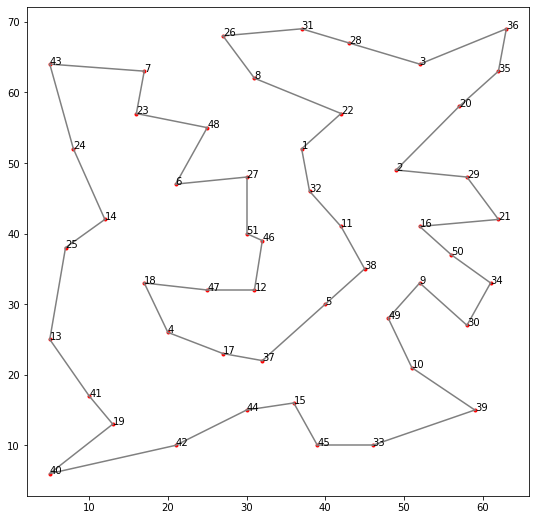

length = 429.98331198338406


In [12]:

nodes = np.loadtxt('TSP/eil51.tsp.txt', skiprows = 6, max_rows = 51)
opt_tour = np.loadtxt('TSP/eil51.opt.tour.txt', skiprows = 5, max_rows = 51)

d_nodes = {}
for node in nodes: 
    d_nodes[node[0]] = (node[1], node[2])


opt_tour_paths = []

for i, node in enumerate(opt_tour):
    if i < len(opt_tour) - 1: 
        opt_tour_paths.append([node, opt_tour[i+1]])
    else:
        opt_tour_paths.append([node, opt_tour[0]])


plt.figure(figsize = (9,9))
for node in nodes:
    plt.plot(node[1], node[2], 'r.')
    plt.annotate(int(node[0]), (node[1], node[2]))

for path in opt_tour_paths: 
    x_coords = [d_nodes[path[0]][0], d_nodes[path[1]][0]]
    y_coords =[d_nodes[path[0]][1], d_nodes[path[1]][1]]
    plt.plot(x_coords, y_coords, color = 'grey')

def tour_length(tour_paths):
    total_length = 0
    total_length_manual = 0
    for path in tour_paths:
        x_coords = [d_nodes[path[0]][0], d_nodes[path[1]][0]]
        y_coords =[d_nodes[path[0]][1], d_nodes[path[1]][1]]
        length = distance.euclidean((x_coords[0], y_coords[0]), (x_coords[1], y_coords[1]))
        length_manual = np.sqrt((x_coords[0] - x_coords[1])**2 + (y_coords[0] - y_coords[1])**2)
        if length < 5: 
            print(length)
        total_length += length
        total_length_manual += length_manual
    return total_length, total_length_manual

def tour_length(tour):
    total_length_manual = 0

    for i, node in enumerate(tour):
        
        if i >= len(tour) - 1: 

            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[0]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[0]][1]

        else:  
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[i+1]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[i+1]][1]

       
        length_manual = np.sqrt((x1 - x2)**2 + (y1-y2)**2)
        
        total_length_manual += length_manual
    return total_length_manual

plt.show()

print('length = ' + str(tour_length(opt_tour)))


